# embedding fields

In [ ]:
import itertools
import tqdm.auto as tqdm

import ee
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
years = list(range(2017, 2024))  # Generates [2018, 2019, 2020, 2021, 2022, 2023]
# for all combinations of years, uncomment the next line
# year_pairs = [list(pair) for pair in itertools.combinations(years, 2)]
year_pairs = [[2018, 2023]]

print(year_pairs)

[[2018, 2023]]


In [ ]:
efmV2 = ee.ImageCollection('projects/mldp-partners/assets/preview/efm_v2_preview')

# for a point, compute change vectors between all possible year combinations
def embeddingByYear(year):
    return efmV2\
        .filterDate(ee.Date.fromYMD(year,1,1), ee.Date.fromYMD(year,1,1).advance(1, 'year'))\
        .mosaic().pow(2).reduce(ee.Reducer.sum()).sqrt()

def dotProduct(year1, year2):
    #Calculate the dot product.
    dot = embeddingByYear(year1)\
    .multiply(embeddingByYear(year2))\
    .reduce(ee.Reducer.sum())\
    .multiply(-1)\
    .add(1)
    period = ee.String(year2).cat('_').cat(ee.String(year1))
    return dot.selfMask().rename(period)

# extract data
def extractData(point, scale):
    
    changeBands = ee.ImageCollection(ee.List(year_pairs).map(lambda yearList: dotProduct(ee.List(yearList).getNumber(1),
                                                                ee.List(yearList).getNumber(0)))).toBands()\
                                                                    .regexpRename('^[^_]*_', '') #remove all up to and including first underscore
    mean = changeBands.reduceRegion(
            reducer=ee.Reducer.mean(), 
            geometry=point, 
            scale=scale
        )
    
    return ee.Feature(point).set(mean)
    
# eeprint(extractData(point, 30))       

In [ ]:
# extract values at points
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/aliens_sep2018')#.filter(ee.Filter.eq('fid',238))

output = pts.map(lambda ft: extractData(ft.geometry(), 30))
# output = extractData(pts.geometry(), 30)

# convert to geopandas dataframe
pts_gdf = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(output),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
pts_gdf.crs = 'EPSG:4326'

display(type(pts_gdf))
pts_gdf.head()

geopandas.geodataframe.GeoDataFrame

,geometry,2018_2023
0,POINT (19.46856 -33.88168),0.013475
1,POINT (19.4689 -33.88104),0.006865
2,POINT (19.47297 -33.88195),0.010611
3,POINT (19.47367 -33.87662),0.026942
4,POINT (19.46506 -33.88506),0.002919


In [ ]:
pts_gdf.to_file('/home/geethen/invasives/hypinvalimap/data/2018_2023_MgnChg.shp')

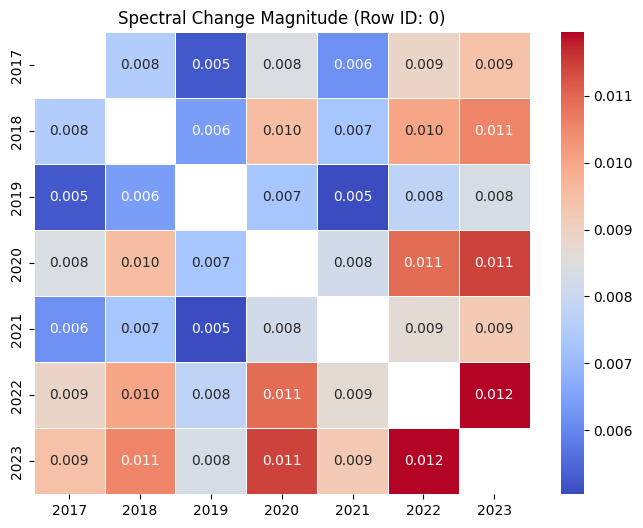

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select a specific row by ID (Index)
row_id = 0  # Change this to select different rows
df = pts_gdf
selected_row = df.iloc[row_id, 1:]  # Exclude 'geometry'

# Extract years from column names
years = sorted(set(int(y) for col in selected_row.index for y in col.split('_')))

# Create an empty DataFrame for the heatmap
change_matrix = pd.DataFrame(np.nan, index=years, columns=years)

# Populate the heatmap with values from the selected row
for col, value in selected_row.items():
    y1, y2 = map(int, col.split('_'))
    change_matrix.loc[y1, y2] = value
    change_matrix.loc[y2, y1] = value  # Make it symmetric

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(change_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title(f"Spectral Change Magnitude (Row ID: {row_id})")
plt.show()


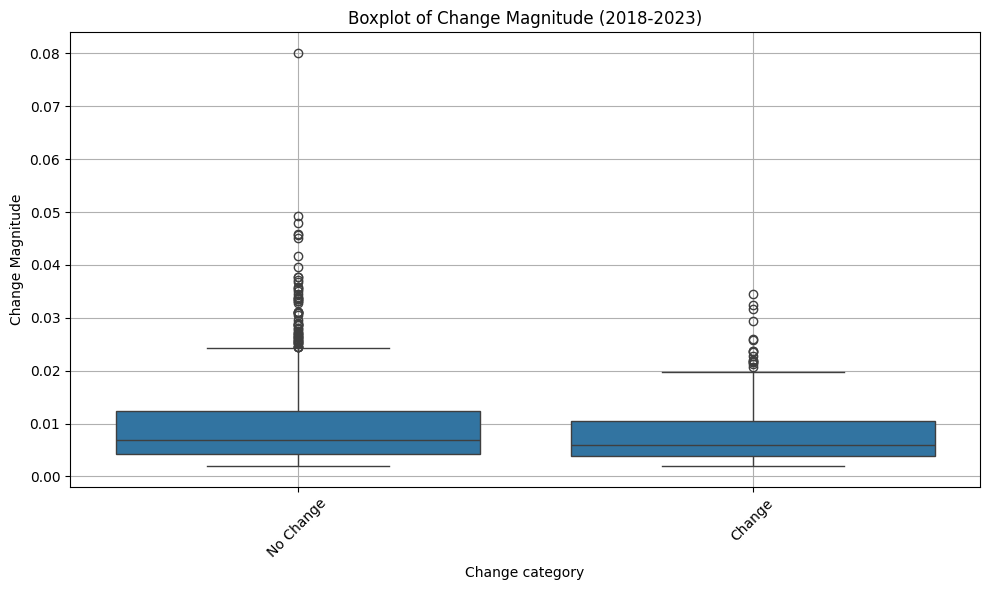

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load shapefile and clean null geometries
points = gpd.read_file('/home/geethen/invasives/hypinvalimap/data/2018_2023_MgnChg.shp')
points = points[points['geometry'].notnull()]

# Optional: drop rows with NaN in relevant columns
points = points.dropna(subset=['2018_2023', 'change'])  # assuming 'change_category' exists

def plot_boxplot(df, category_col, value_col, title, xticklabels=None):
    """
    Plot a boxplot of value_col grouped by category_col.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        category_col (str): Name of the categorical column for x-axis.
        value_col (str): Name of the numerical column for y-axis.
        title (str): Plot title.
        xticklabels (list, optional): Custom labels for x-axis categories.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_col, y=value_col, data=df)
    plt.title(title)
    plt.xlabel('Change category')
    plt.ylabel('Change Magnitude')

    if xticklabels:
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot assuming a categorical column like 'change_category'
plot_boxplot(points, 'change', '2018_2023', 'Boxplot of Change Magnitude (2018-2023)', ['No Change', 'Change'])
